# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
survey_fields.remove('DBN')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
survey_fields.append('sat_score')

In [13]:
correlations = combined[survey_fields].corr()
correlations = correlations['sat_score']

In [14]:
print(correlations)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64


In [15]:
bar_positions = numpy.arange(len(correlations))

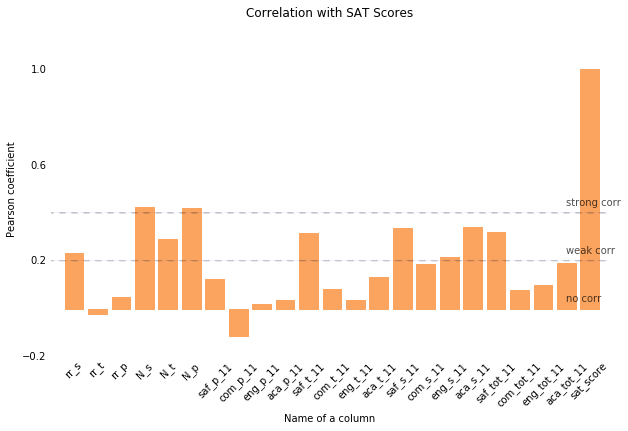

In [16]:
fig1 = plt.figure(figsize=(10,6))
ax = fig1.add_subplot(1, 1, 1)
ax.bar(bar_positions, correlations, align='center', color='sandybrown', edgecolor='sandybrown')
ax.set_xticks(bar_positions)
ax.set_xticklabels(survey_fields, rotation=45)
ax.set_xlim(-1, 22.8)
ax.set_ylim(-0.2, 1.2)
ax.set_yticks(numpy.arange(-0.2, 1.2, 0.4))
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.arrow(x=-1, y=0.4, dx=24, dy=0, alpha=0.2, linestyle='--')
ax.annotate('strong corr', xy=(21,0.43), alpha=0.7)
ax.arrow(x=-1, y=0.2, dx=24, dy=0, alpha=0.2, linestyle='--')
ax.annotate('weak corr', xy=(21,0.23), alpha=0.7)
ax.annotate('no corr', xy=(21, 0.03), alpha=0.7)
plt.title('Correlation with SAT Scores')
ax.set_xlabel('Name of a column')
ax.set_ylabel('Pearson coefficient')
plt.show()

<p>The strongest correlation with sat scores is among N_s, N_p columns, which contain information about number of student and parent responders, respectively. Those are the only columns which's correlation can be called 'strong'.<br>
Strong influence can be also observed in columns comprising of data about safety and respect among teachers and students and academic expectations.</p>

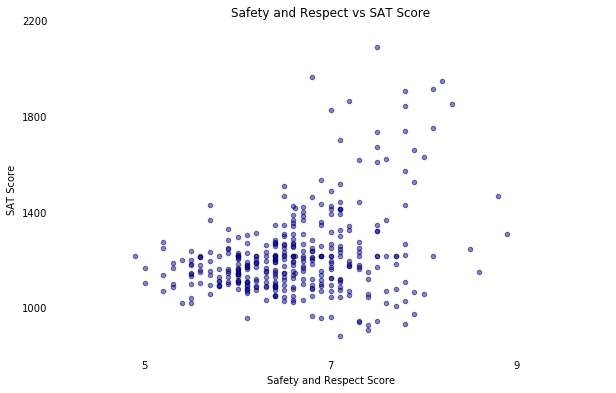

In [17]:
fig2 = plt.figure(figsize=(10,6))
ax = fig2.add_subplot(1,1,1)
ax.scatter(x=combined['saf_s_11'], y=combined['sat_score'], alpha=0.5)
ax.tick_params(left=False, right=False, bottom=False, top=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks(numpy.arange(1000,2201,400))
ax.set_xticks(numpy.arange(5, 11, 2))
plt.title('Safety and Respect vs SAT Score')
ax.set_xlabel('Safety and Respect Score')
ax.set_ylabel('SAT Score')
plt.show()

<p>Above we can see that there is some positive correlation between SAT score and school's safety and respect.</p>

In [18]:
by_dist = combined.groupby('school_dist').agg(numpy.mean)

In [19]:
from mpl_toolkits.basemap import Basemap

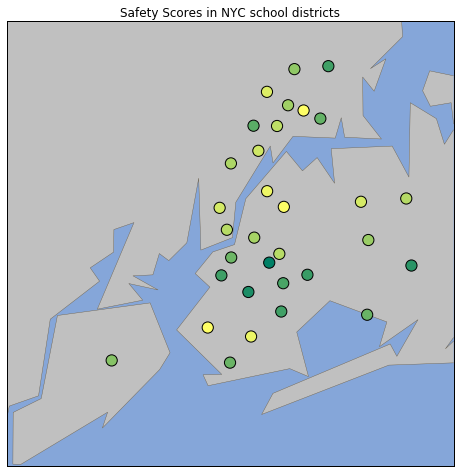

In [20]:
fig = plt.figure(figsize=(8,8))
m = fig.add_subplot(1,1,1)
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i',
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='silver')

longitudes = by_dist['lon'].tolist()
latitudes = by_dist['lat'].tolist()

m.scatter(longitudes, latitudes, s=125, latlon=True, zorder=2, c=by_dist['saf_s_11'], cmap='summer')
plt.title('Safety Scores in NYC school districts')
plt.show()


<p>On the map up above, the districts with higher Safety Score have yellow color. Based on that we can see that the least safe schools are in Brooklyn, particularly in Flatbush, Crown Heights, Bedford, Brownsville neighbourhoods. On the other hand, west Queens and Manhattan seem to be rather safe.</p>

In [21]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
race_corrs = combined[race_cols].corr()['sat_score']
race_corrs = race_corrs.drop('sat_score')

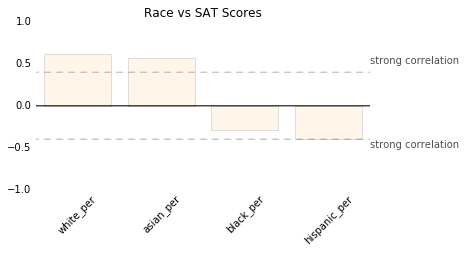

In [45]:
bar_positions = numpy.arange(len(race_corrs))

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(bar_positions, race_corrs, alpha=0.5, align='center', color='papayawhip', edgecolor='silver')
ax.set_xticks(bar_positions)
ax.set_xticklabels(race_cols, rotation=45)
ax.set_yticks(numpy.arange(-1.0, 1.01, 0.5))
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.arrow(x=-0.5, y=0.4, dx=4, dy=0, alpha=0.2, linestyle='--')
ax.annotate('strong correlation', xy=(3.5,0.50), alpha=0.7)
ax.arrow(x=-0.5, y=-0.4, dx=4, dy=0, alpha=0.2, linestyle='--')
ax.arrow(x=-0.5, y=0, dx=4, dy=0, alpha=0.7)
ax.annotate('strong correlation', xy=(3.5,-0.50), alpha=0.7)
plt.title('Race vs SAT Scores')
plt.show()

<p>There are strong positive correlations between white and asian students population and sat scores. And weak negative correlation between black and hispanic students and sat scores.</p>

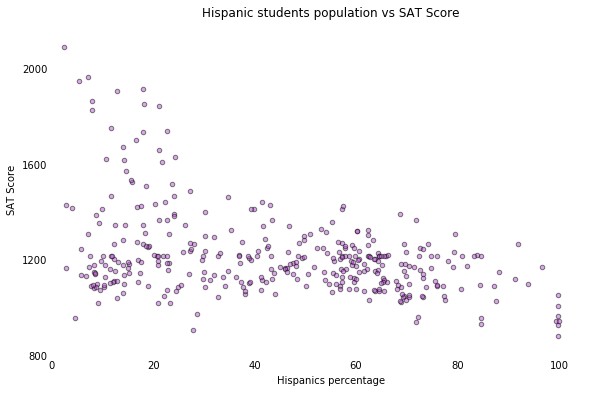

In [23]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=combined['hispanic_per'], y=combined['sat_score'], alpha=0.5, c='mediumorchid')
ax.tick_params(left=False, right=False, bottom=False, top=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,110)
ax.set_yticks(numpy.arange(800,2201,400))
ax.set_xticks(numpy.arange(0, 110, 20))
plt.title('Hispanic students population vs SAT Score')
ax.set_xlabel('Hispanics percentage')
ax.set_ylabel('SAT Score')
plt.show()

<p>Scatter plot ensures us that, in fact, there is a negative correlation between hispanic studenst percentage and SAT Scores, although it is not very strong.</p>

In [24]:
his_95 = combined[combined['hispanic_per'] >= 95]
his_95['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

<p>There are 8 schools where hispanic population is over 95%. Those school are mainly on the outskirts od NYC. They have exceptionally high rates of economically disadvantaged students. Those schools are badly placed in national and regional rankings.</p>

In [25]:
his_10 = combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] >= 1800)]
his_10['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

<p>There are 5 schools in which hispanic population is less than 10% and average sat score are higher than 1800. Those schools have very high percentage of asian students and are ranked among the best in the States.</p>

In [30]:
male_female = combined[['male_per', 'female_per', 'sat_score']]
mf_corrs = male_female.corr()['sat_score']
mf_corrs = mf_corrs.drop('sat_score')
mf_corrs

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

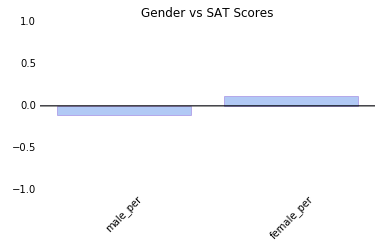

In [50]:
bar_positions = numpy.arange(len(mf_corrs)) + 0.5

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(bar_positions, mf_corrs, alpha=0.5, align='center', color='cornflowerblue', edgecolor='mediumpurple')
ax.set_xticks(bar_positions)
ax.set_xticklabels(male_female, rotation=45)
ax.set_yticks(numpy.arange(-1, 1.01, 0.5))
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.arrow(x=-0.5, y=0, dx=4, dy=0, alpha=0.7)
ax.annotate('weak corr', xy=(21,0.23), alpha=0.7)
plt.title('Gender vs SAT Scores')
plt.show()

<p>There isn't a very strong correlation between SAT scores and male or female share of students.</p>

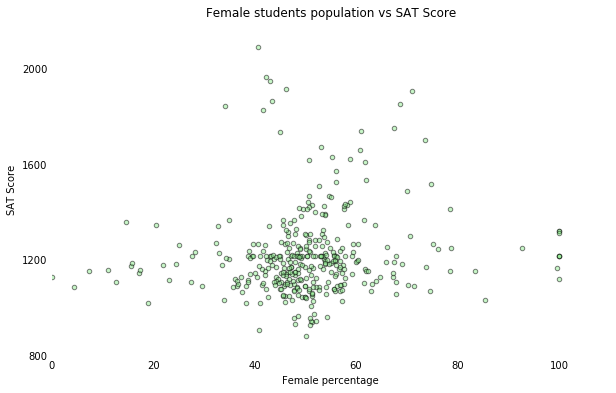

In [53]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=combined['female_per'], y=combined['sat_score'], alpha=0.5, c='lightgreen')
ax.tick_params(left=False, right=False, bottom=False, top=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,110)
ax.set_yticks(numpy.arange(800,2201,400))
ax.set_xticks(numpy.arange(0, 110, 20))
plt.title('Female students population vs SAT Score')
ax.set_xlabel('Female percentage')
ax.set_ylabel('SAT Score')
plt.show()

<p>The scatter plot confirms our previous observation. There seem to be no correlation between female students share and average SAT scores.</p>

In [59]:
high_per_fem = combined[(combined['female_per'] >= 60) & (combined['sat_score'] >= 1700)]
high_per_fem['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

<p>Out of schools that have a high share of female students and high average SAT scores (above), most are located in Manhattan. Those schools also put a higher preassure on humanistic studies.</p>

In [65]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

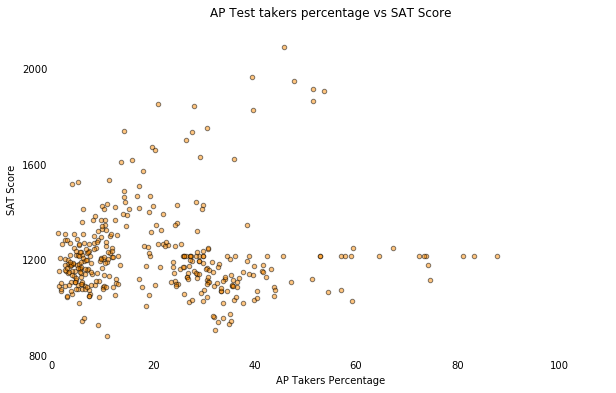

In [68]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=combined['ap_per'], y=combined['sat_score'], alpha=0.5, c='darkorange')
ax.tick_params(left=False, right=False, bottom=False, top=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,110)
ax.set_yticks(numpy.arange(800,2201,400))
ax.set_xticks(numpy.arange(0, 110, 20))
plt.title('AP Test takers percentage vs SAT Score')
ax.set_xlabel('AP Takers Percentage')
ax.set_ylabel('SAT Score')
plt.show()

<p>We can see, maybe suprisigly, that there is no correaltion between AP test takers and SAT scores.</p>